# Anomaly detection

The goal of this notebook is to show some strategies to find outliers in a dataset.
- In **Unsupervised anomaly detection** we know that a few outliers are included in the dataset. We may use two approaches:
    - Unsupervised outlier detector algorithms: Identify a high density cloud of data points close to each other and have them marked as normal (inliers), and assume that those data points outside of this cloud are outliers.
    - Clustering analysis: Assume that there are two custers of data: one that groups normal data, and the other cluster groups the outliers.
- In **Semi-supervised anomaly detection** we know that outliers are not included in the dataset, so we only have normal data for training. It learns the common characteristics of normal data and sets a threshold of what a normal data item should be. Test points are then measured to asses their closeness to this threshold. There are two approaches:
    - Using different metrics to measure distance from each test point to the normal data centroid to see if it exceeds the threshold.
    - Using a Neural Network Autoencoder error loss as a threshold distance to assess normality.

Jose Quinonez

### Wine dataset
Dataset Information

The original Wine dataset from UCI machine learning repository is a multiclass classification dataset having 13 attributes and 3 classes. These data are the results of a chemical analysis of wines grown in the same region in Italy but derived from three different cultivars. The analysis determined the quantities of 13 constituents found in each of the three types of wines. Class 2 and 3 are used as inliers and class 1 is downsampled to 10 instances to be used as ouliers. Dataset from http://odds.cs.stonybrook.edu .

The first 30 instances will be left as test data (10 outliers and 20 inliers), and the remaining instances (99 inliers) will be used as training data.

The attributes are (dontated by Riccardo Leardi, riclea@anchem.unige.it): <br>
1)  Alcohol <br>
2)  Malic acid <br>
3)  Ash<br>
4)  Alcalinity of ash <br>
5)  Magnesium <br>
6)  Total phenols <br>
7)  Flavanoids <br>
8)  Nonflavanoid phenols<br> 
9)  Proanthocyanins <br>
10) Color intensity <br>
11) Hue v
12) OD280/OD315 of diluted wines<br> 
13) Proline <br>

### Source (citation)

Saket Sathe and Charu C. Aggarwal. LODES: Local Density meets Spectral Outlier Detection. SIAM Conference on Data Mining, 2016.


_________________________________________________________________________

#### Load libraries

In [24]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd

%matplotlib inline
import matplotlib.pyplot as plt

from collections import Counter
import seaborn as sns

from sklearn.decomposition import PCA
from sklearn.metrics import pairwise_distances
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture

from sklearn.metrics import recall_score, precision_score

from sklearn import svm
from sklearn.covariance import EllipticEnvelope
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor

from sklearn.covariance import MinCovDet , EmpiricalCovariance
from scipy.spatial import distance as scipy_distance

from sklearn.preprocessing import StandardScaler
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms


#### Prepare helper functions

In [25]:
# Helper function to plot 2 variables
def plot2dims(var_x, var_y, num_classes, title, x_title, 
              y_title, horizontal_line=None, vertical_line=None):
    x_min, x_max = np.min(var_x)-1, np.max(var_x)+1
    y_min, y_max = np.min(var_y)-1, np.max(var_y)+1
    plt.figure(2, figsize=(20, 10))
    plt.clf()

    plt.scatter(var_x, var_y, c=num_classes, cmap=plt.cm.bwr,
                edgecolor='k', alpha=0.7)
    plt.xlabel(x_title, size=22)
    plt.ylabel(y_title, size=22)
    plt.title(title, size=22)

    plt.xlim(x_min, x_max)
    plt.ylim(y_min, y_max)
    plt.xticks(())
    plt.yticks(())
    if horizontal_line is not None:
        plt.axhline(y=horizontal_line, color='g',
                    linestyle='dashed', linewidth=1)
    if vertical_line is not None:
        plt.axvline(x=vertical_line, color='g',
                    linestyle='dashed', linewidth=1)    
    plt.show()

In [26]:
# Helper function to reduce dimensionality using PCA
def convertToPCA(X, n_components=2):
    X_reduced = PCA(n_components).fit_transform(X)
    return X_reduced

In [27]:
def show_heatmap(y_pred, y, heat_title):
    results = np.stack((y, y_pred), axis = 1)
    results = [tuple(element) for element in results]
    results_heatmap = np.zeros((2,2))
    for i in range(2):
        for j in range(2):
            results_heatmap[i,j] = Counter(results)[i,j]
    results_heatmap = results_heatmap.astype(int)
    sns.set(font_scale=2)
    ax = sns.heatmap(data=results_heatmap, annot=True, fmt="d",
                     cmap="YlGnBu", cbar=False,
                    xticklabels = ["Inlier", "Outlier"],
                     yticklabels = ["Inlier", "Outlier"],
                    annot_kws={"fontsize":15})
    

    plt.title(heat_title, fontsize = 20)
    plt.xlabel('Predicted', fontsize = 20)
    plt.ylabel('Actual', fontsize = 20)

    plt.show()

In [28]:
# Helper funtion to plot histogram
def plotHist(distance, metric):
    plt.figure(figsize=(10, 6))
    plt.hist(distance, 20, density=True, stacked=True, 
             cumulative=False, facecolor='g', alpha=0.75)
    plt.xlabel('Distance', size=15)
    plt.ylabel('Probability', size=15)
    plt.title('Histogram of Distances using '+metric, size=20)
    plt.grid(True)
    plt.show()

In [29]:
# Helper funtion to calculate loss 
def get_loss(model, criterion, data_loader): 
    loss = np.zeros(len(data_loader))
    for ix, data in enumerate(data_loader):
        flatten_data = data.view(batch_size, -1)
        # get sample outputs
        output = model(flatten_data)
        loss[ix] = criterion(output, flatten_data).detach().numpy()
    return loss

#### Load data from current folder

In [30]:
df=pd.read_csv('wine.csv', sep=',',header=None)
print("Number of total rows and columns:", df.shape)

Number of total rows and columns: (129, 14)


In [31]:
print("First five rows of data:")
df[df.columns[:-1]].head(5)

First five rows of data:


,0,1,2,3,4,5,6,7,8,9,10,11,12
0,13.29,1.97,2.68,16.8,102,3.00,3.23,0.31,1.66,6.00,1.07,2.84,1270
1,14.30,1.92,2.72,20.0,120,2.80,3.14,0.33,1.97,6.20,1.07,2.65,1280
2,13.68,1.83,2.36,17.2,104,2.42,2.69,0.42,1.97,3.84,1.23,2.87,990
3,14.06,2.15,2.61,17.6,121,2.60,2.51,0.31,1.25,5.05,1.06,3.58,1295
4,14.22,1.70,2.30,16.3,118,3.20,3.00,0.26,2.03,6.38,0.94,3.31,970


In [32]:
print("Last five rows of data:")
df[df.columns[:-1]].tail(5)

Last five rows of data:


,0,1,2,3,4,5,6,7,8,9,10,11,12
124,13.71,5.65,2.45,20.5,95,1.68,0.61,0.52,1.06,7.7,0.64,1.74,740
125,13.40,3.91,2.48,23.0,102,1.80,0.75,0.43,1.41,7.3,0.70,1.56,750
126,13.27,4.28,2.26,20.0,120,1.59,0.69,0.43,1.35,10.2,0.59,1.56,835
127,13.17,2.59,2.37,20.0,120,1.65,0.68,0.53,1.46,9.3,0.60,1.62,840
128,14.13,4.10,2.74,24.5,96,2.05,0.76,0.56,1.35,9.2,0.61,1.60,560


There are 129 records and 14 columns. 

Column 14 labels the record as normal(0) or outlier(1).

In [33]:
# Get data into arrays
X = df[df.columns[:-1]].values
y = df[df.columns[-1]].values

# Set the first 30 data points for test data, 
# and the remaining  data for training
X_train = X[30:,:]
y_train = y[30:]
num_distances_train = len(X_train)

X_test = X[:30,:]
y_test = y[:30]
num_distances_test = len(X_test)

#### Reduce dimensionality to two princiàl components to have a visualization

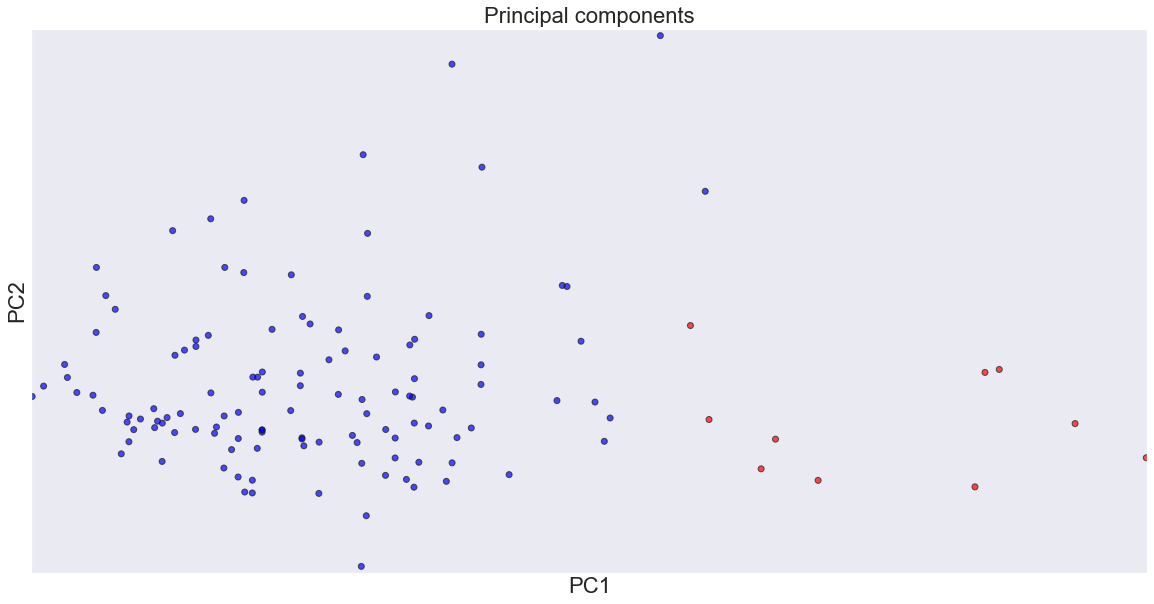

In [34]:
X_reduced = convertToPCA(X)
plot2dims(X_reduced[:,0], X_reduced[:,1], y,
          "Principal components", "PC1", "PC2")

#### Findings:
Reducing feature dimensionality using PCA has helped to visually separate red outliers from blue inliers.

## Unsupervised anomaly detection

These techniques take the full dataset assuming it includes a few outliers. We will use two approaches to distinguish inliers from outliers.

### Unsupervised outlier detector algorithms:
This group of methods assume an statistical proximity between the vast majority of instances in a dense cloud, and a few outliers separated from this cloud.


 Robust covariance : 10 outliers
[1 1 0 1 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 1 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Recall 0.5000
Precision 0.5000


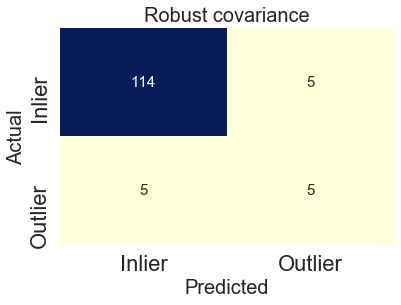


 One-Class SVM : 81 outliers
[0 1 1 1 0 1 0 1 1 0 0 1 0 1 1 1 0 0 1 1 1 1 0 1 1 1 1 1 1 0 1 1 0 1 1 1 1
 1 0 0 0 1 1 0 1 1 1 0 1 1 1 1 0 1 1 0 0 0 0 0 1 1 0 1 1 0 0 1 1 0 0 1 1 1
 0 0 0 1 1 1 0 0 1 0 0 1 1 0 1 1 1 1 1 1 0 1 0 1 1 1 1 1 1 1 0 1 0 0 0 0 1
 0 0 1 1 1 0 1 1 1 1 1 1 0 1 1 1 0 0]
Recall 0.6000
Precision 0.0741


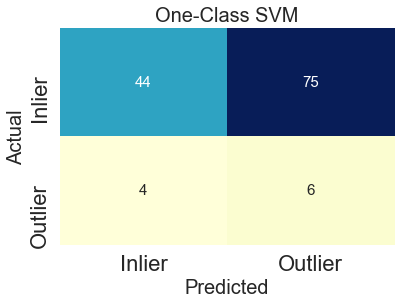


 Isolation Forest : 10 outliers
[0 0 0 0 1 0 0 0 1 0 1 0 0 0 0 0 0 1 0 0 1 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Recall 0.2000
Precision 0.2000


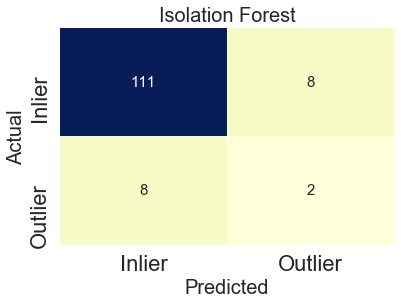


 Local Outlier Factor : 10 outliers
[1 1 1 1 0 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Recall 0.9000
Precision 0.9000


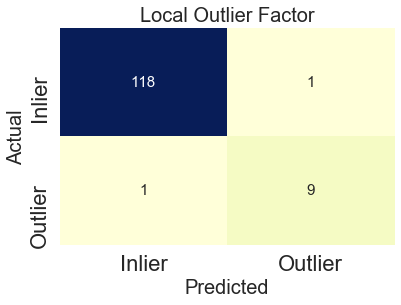

In [35]:
# Use Unsupervised outlier algorithms

random_state=10

# Pre-set the approximate percentage of expected outliers
outliers_fraction = 10/129

# Define algorithms
anomaly_algorithms = [
    ("Robust covariance", EllipticEnvelope(contamination=outliers_fraction)),
    ("One-Class SVM", svm.OneClassSVM(nu=outliers_fraction, kernel="rbf",
                                      gamma=0.1)),
    ("Isolation Forest", IsolationForest(contamination=outliers_fraction,
                                         random_state=random_state)),
    ("Local Outlier Factor", LocalOutlierFactor(
        n_neighbors=35, contamination=outliers_fraction))]

# Run for every algorithm
for name, algorithm in anomaly_algorithms:
        algorithm.fit(X)
        # fit the data and tag outliers
        if name == "Local Outlier Factor":
            y_pred = algorithm.fit_predict(X)
        else:
            y_pred = algorithm.fit(X).predict(X)
        # invert 0's by 1's and viceversa for presentation purposes        
        for i in range(len(y_pred)):
            if y_pred[i] == -1:
                y_pred[i] = 1
            else:
                y_pred[i] = 0
        print("\n",name, ":",(y_pred==1).sum(), "outliers")
        print(y_pred)
        print("Recall {0:.4f}".format(recall_score(y, y_pred)))
        print("Precision {0:.4f}".format(precision_score(y, y_pred)))
        show_heatmap(y_pred, y, name)

#### Findings
Local Outlier Factor achieved the best recall and precision measurements. If the expected percentage of outliers could be a little more, we could get 100% recall and a good precision with just a few false negatives.

### Clustering analysis

Clustering analysis uses different algorithms to identify groups of data items with similar data attributes among the group member, and different data attributes against other groups.

In this exercise, we intentionally force for two groups: the normal data group versus the outliers group.


 KMeans : 19 outliers
[1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0]
Recall 1.0000
Precision 0.5263


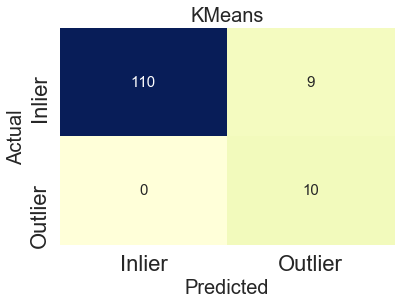


 AggClist : 19 outliers
[1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0]
Recall 1.0000
Precision 0.5263


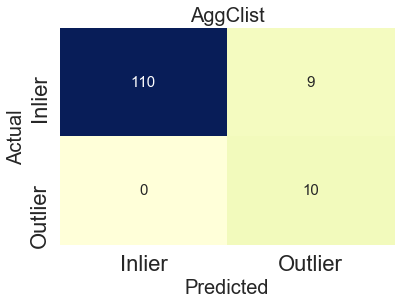


 GausMix : 21 outliers
[1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 1 0 0 0 1 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 1 0 0 0 1 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0]
Recall 1.0000
Precision 0.4762


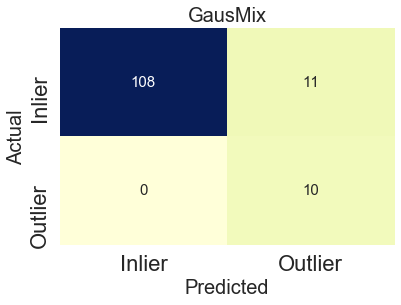

In [36]:
# Use clustering analysis aasuming two clusters
n_clusters=2
metric = "euclidean"

# Define clustering algorithms
dict_models = {"KMeans" : KMeans(n_clusters=n_clusters,
                                 random_state=random_state),
              "AggClist": AgglomerativeClustering(n_clusters=n_clusters,
                                linkage="complete", 
                                affinity=metric),
              "GausMix" : GaussianMixture(n_components=2, 
                                          covariance_type="full",
                                          init_params="kmeans",
                                          random_state=random_state)}
# Run for every algorithm
for model_key in dict_models:
    model = dict_models[model_key]
    model.fit(X)
    if hasattr(model, 'labels_'):
        y_pred = model.labels_.astype(np.int)
    else:
        y_pred = model.predict(X)
    # invert 0's by 1's and viceversa for presentation purposes 
    y_pred = np.logical_not(y_pred).astype(int)
    
    print("\n",model_key, ":",(y_pred==1).sum(), "outliers")
    print(y_pred)
    print("Recall {0:.4f}".format(recall_score(y, y_pred)))
    print("Precision {0:.4f}".format(precision_score(y, y_pred)))
    show_heatmap(y_pred, y, model_key)

#### Findings:

The three algorithms succeeded in finding the true positive labels, but all of them missed some false negatives.
K-means and Aggregative Clustering algorithms did a slightly better job in predicting the cluster id for data items.


Local Outlier Factor seemed to be the best method from the Unsupervised Anomaly detectors. Ot did much better than all the clustering methods too.

## Semi-supervised anomaly detection

These techniques requires to define normality from inliers' data attributes, and then compare how close to this normality is a new test data point.
We use a subset of data for training (inliers), and the remaining data for testing (inliers and outliers).

### Linear distances from centroid

The first approach is to measure the distance from each normal data point to the overall groupd centroid. One expect that those distances follow a normal distributio, so one can set a distance threshold, a reasonable limit of what is normal.
Test instances will be measured against this threshold.

Several measurements of distances are used to show the differences.

In [37]:
# Calculate the normal data's centroid
X_train_centroid = np.mean(X_train, axis=0)

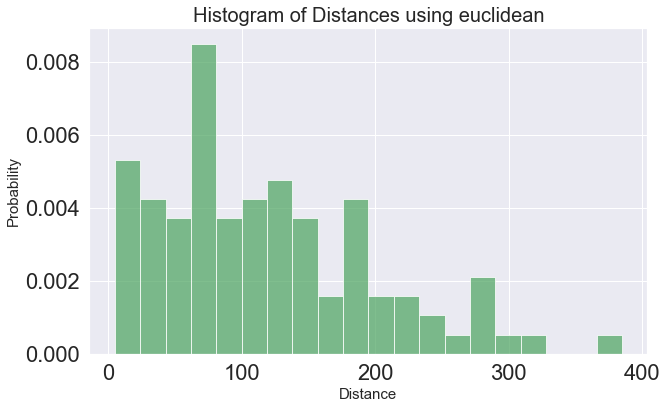

Percentile 99.50 is 354.4


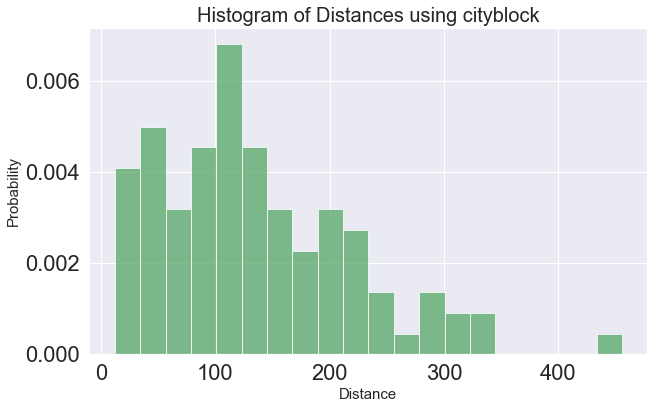

Percentile 99.00 is 337.6


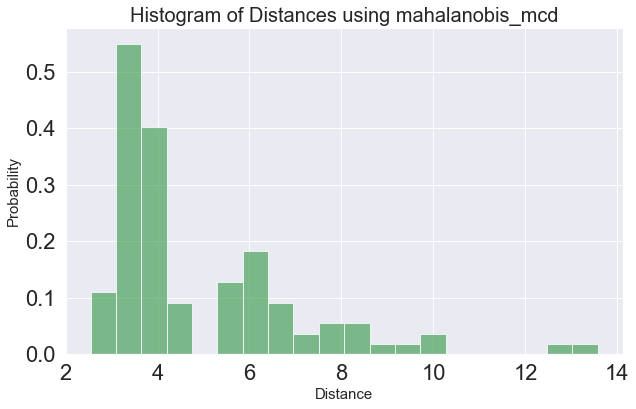

Percentile 99.00 is 12.7


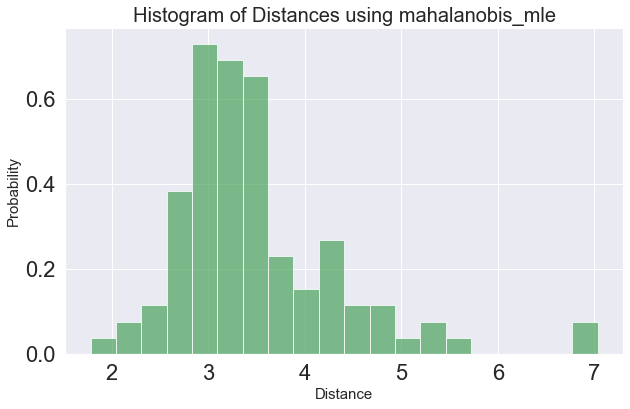

Percentile 99.00 is 6.8


In [38]:
# define metrics
dict_metrics = {"euclidean" : {"metric":"euclidean",
                               "threshold":99.5,
                               "distance_threshold":0},
                "cityblock" : {"metric":"cityblock",
                               "threshold":99.0,
                               "distance_threshold":0},
                "mahalanobis_mcd" : {"metric":"mahalanobis",
                               "threshold":99.0,
                               "distance_threshold":0,
                                "cov_matrix":None},
                "mahalanobis_mle" : {"metric":"mahalanobis",
                               "threshold":99.0,
                               "distance_threshold":0,
                                "cov_matrix":None} 
               }
# Run for every metric
for index, metric_key in enumerate(dict_metrics):
    metric = dict_metrics[metric_key]["metric"]
    threshold = dict_metrics[metric_key]["threshold"]
    distance = np.zeros(num_distances_train)
    
    # Calculate distances from normal data points to their centroid
    if metric == "mahalanobis" :
        if metric_key == "mahalanobis_mcd":
            cov_matrix = MinCovDet(random_state=random_state).fit(X_train)
        else:
            cov_matrix = EmpiricalCovariance().fit(X_train) 
        dict_metrics[metric_key]["cov_matrix"] = cov_matrix
        distance = np.sqrt(cov_matrix.mahalanobis(X_train))
    else:
        for i in range(num_distances_train):
            distance[i] = pairwise_distances(X_train[i].reshape(1,-1),
                                             X_train_centroid.reshape(1,-1),
                                             metric=metric).flatten()  
    
    # Calculate a threshold based on the 99 percentile
    distance_threshold = np.percentile(distance, threshold)
    dict_metrics[metric_key]["distance_threshold"] = distance_threshold
    
    # Plot the distribution of normal distances
    plotHist(distance, metric_key)
    print("Percentile {0:.2f} is {1:.1f}".
          format(threshold, distance_threshold) )

euclidean : 11 outliers
[1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0]

Recall 1.0000
Precision 0.9091


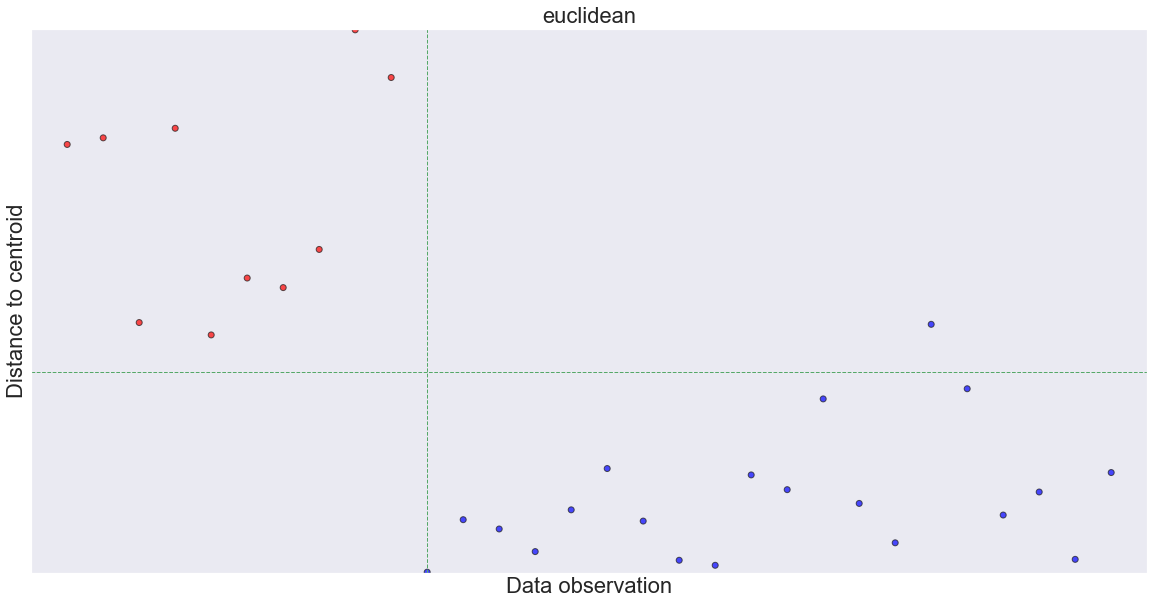

cityblock : 12 outliers
[1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0]

Recall 1.0000
Precision 0.8333


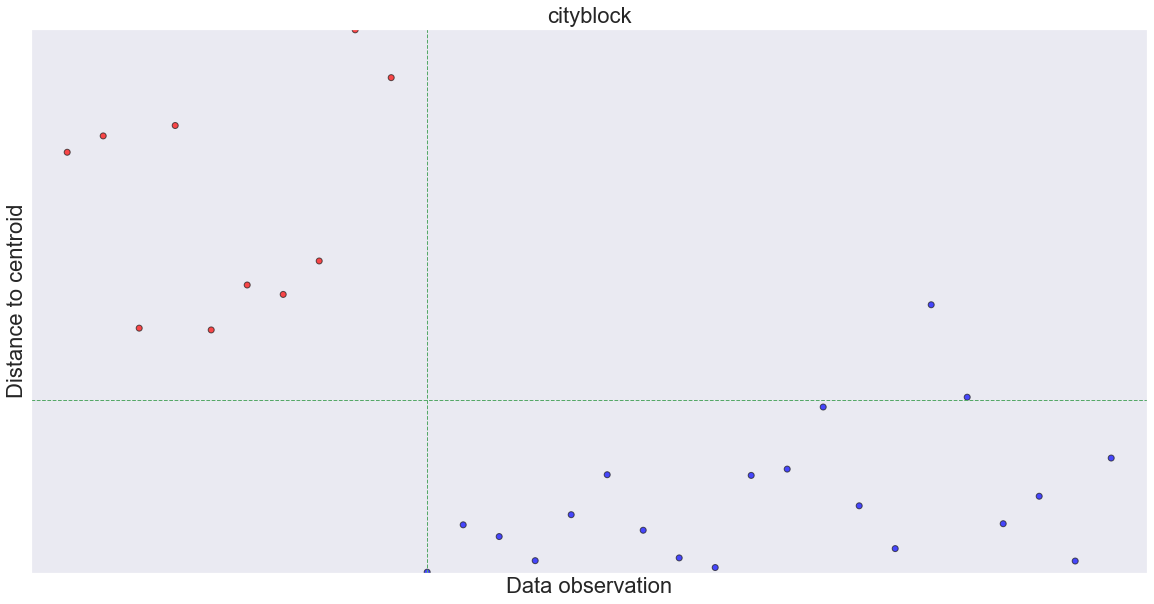

mahalanobis_mcd : 2 outliers
[0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]

Recall 0.2000
Precision 1.0000


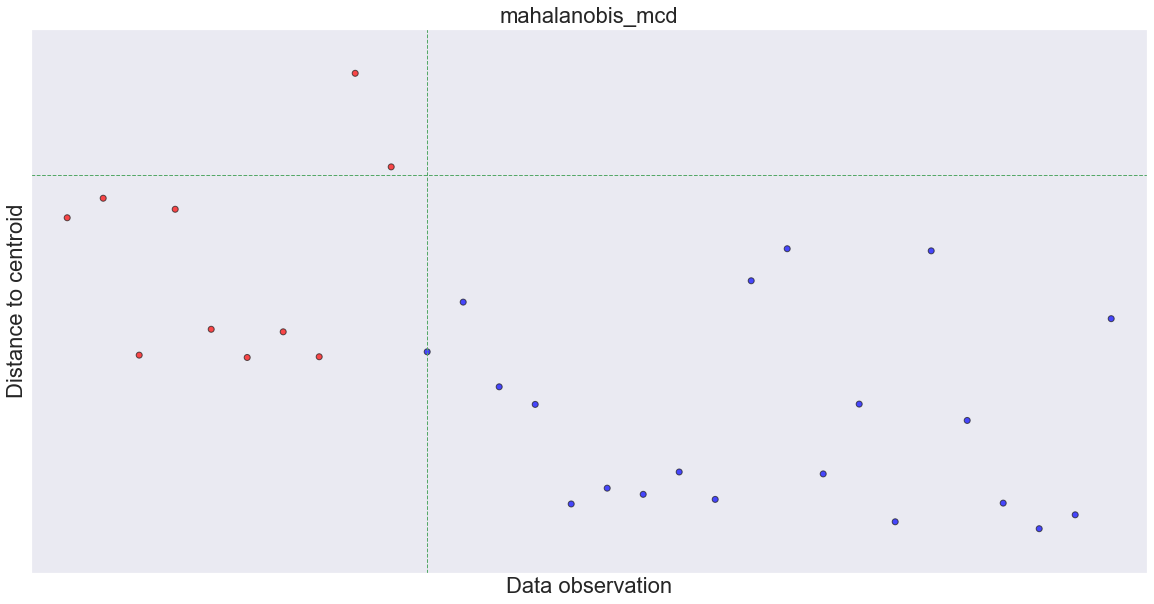

mahalanobis_mle : 10 outliers
[1 1 0 1 1 1 1 0 1 1 0 0 0 0 0 0 0 0 0 0 1 0 0 0 1 0 0 0 0 0]

Recall 0.8000
Precision 0.8000


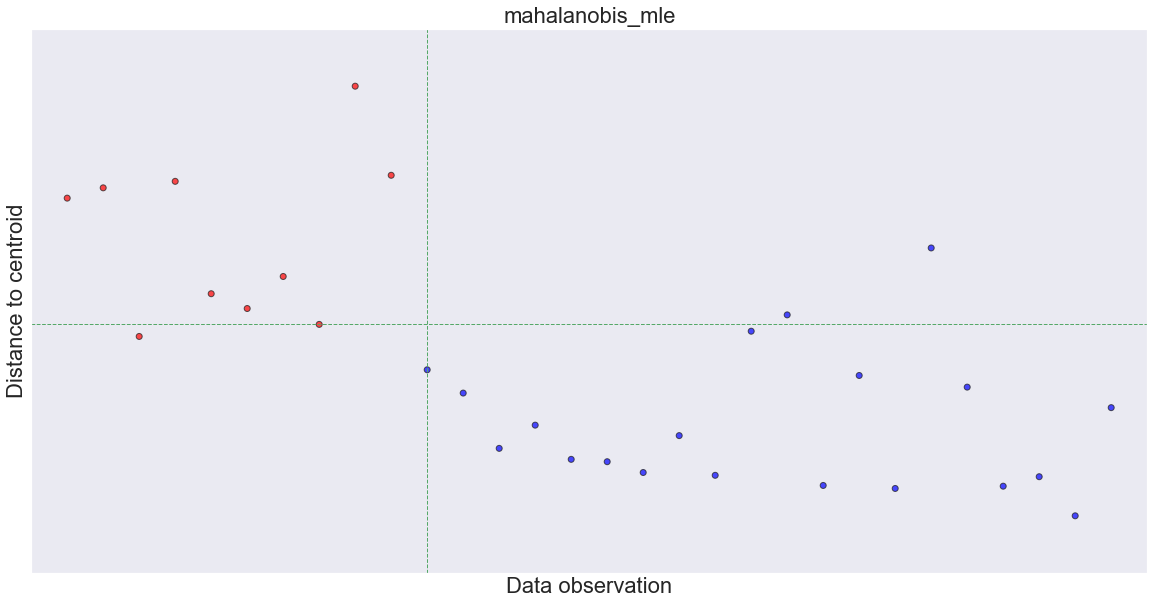

In [39]:
# Evaluate the distances for every test data point using every metric

for index, metric_key in enumerate(dict_metrics):
    metric = dict_metrics[metric_key]["metric"]
    distance_threshold = dict_metrics[metric_key]["distance_threshold"]
    distance = np.zeros(num_distances_test)
    pred = np.zeros(num_distances_test).astype(int)
    
    # Calculate distance from test point to normal data centroid
    if metric == "mahalanobis" :
        cov_matrix = dict_metrics[metric_key]["cov_matrix"]
        cov = cov_matrix.covariance_
        cov_inv = np.linalg.inv(cov) 
        for i in range(num_distances_test):
            distance[i] = scipy_distance.mahalanobis(X_test[i],
                                                     X_train_centroid,
                                                     cov_inv)
            # Mark instance as outlier if distance is beyond threshold
            if distance[i] >= distance_threshold:
                pred[i] = 1
    else:
        for i in range(num_distances_test):
            distance[i] = pairwise_distances(X_test[i].reshape(1,-1),
                                             X_train_centroid.reshape(1,-1),
                                             metric=metric).flatten()
            if distance[i] >= distance_threshold:
                pred[i] = 1
                     
    print(metric_key, ":",(pred==1).sum(),"outliers")
    
    # The first 10 data items are known outliers
    
    print(pred)
    print("\nRecall {0:.4f}".format(
        recall_score(y_test, pred)))
    print("Precision {0:.4f}".format(
        precision_score(y_test, pred)))
    
    plot2dims(range(num_distances_test), distance, y_test,
              metric_key, "Data observation", "Distance to centroid", 
              horizontal_line = distance_threshold,
              vertical_line = 10)


#### Findings:
Using euclidean distance was more accurate to detect all true positive outliers (100% recall), and only missed just one false negative (good .90 orecision).


### Semi-supervised anomaly detection using Neural Networks

The second approach for Semi-supervised anomaly detection is to use Neural networks autoencoders, since they can find non-linear patterns.

An autoencoder is a non-recurrent fast-forward neural network whose output layer has the same number of nodes as the input layer, trying to reproduce exactly the same normal data. After having traine the network, One expect that the error loss between the original data and the reproduced data would be a number close to zero and follow a normal distribution.

An outlier would have a higher loss, so it would exceed a defined error loss threshold.

In [40]:
# Scale training data to prepara for neural network
scaler = StandardScaler()
scaler.fit(X_train)
X_train_std = scaler.transform(X_train)
X_test_std = scaler.transform(X_test)

In [41]:
# Define the neural network architecture

dict_nn = {"lr" : 0.001,
           "n_epochs" : 2000,
           "threshold":90.0
          }

class Autoencoder(nn.Module):
    def __init__(self, input_dim, encoding_dim):
        super(Autoencoder, self).__init__()
        ## encoder ##
        self.fc1 = nn.Linear(input_dim, encoding_dim)
        self.fc2 = nn.Linear(encoding_dim, encoding_dim*2)
        self.fc3 = nn.Linear(encoding_dim*2, encoding_dim)
        ## decoder ##
        self.fc4 = nn.Linear(encoding_dim, input_dim)
        

    def forward(self, x):
        # add layer, with relu activation function
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        # output layer (sigmoid for scaling from 0 to 1)
        x = F.sigmoid(self.fc4(x))
        return x

# initialize the network
input_dim = X.shape[1]
encoding_dim = 32
model = Autoencoder(input_dim, encoding_dim)

# specify loss and optimizer functions
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=dict_nn["lr"])

# Convert numpy data to torch
train_data = torch.from_numpy(X_train_std).float()
test_data = torch.from_numpy(X_test_std).float()

# number of subprocesses to use for data loading
num_workers = 0
# how many samples per batch to load
batch_size = 20

# prepare data loaders
train_loader = torch.utils.data.DataLoader(train_data, 
                                           batch_size=batch_size, 
                                           num_workers=num_workers)

In [42]:
# number of epochs to train the model
n_epochs = dict_nn["n_epochs"]

for epoch in range(1, n_epochs+1):
    # monitor training loss
    train_loss = 0.0
    
    ###################
    # train the model with only normal data 
    ###################
    for data in train_loader:
        # _ stands in for labels, here
        images = data
        # flatten images
        images = images.view(images.size(0), -1)
        # clear the gradients of all optimized variables
        optimizer.zero_grad()
        # forward pass: compute predicted outputs by passing inputs to the model
        outputs = model(images)
        # calculate the loss
        loss = criterion(outputs, images)
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # perform a single optimization step (parameter update)
        optimizer.step()
        # update running training loss
        train_loss += loss.item()*images.size(0)
    """      
    # print avg training statistics 
    train_loss = train_loss/len(train_loader)
    if epoch == (n_epochs+1):
        print('Epoch: {} \tTraining Loss: {:.6f}'.format(
            epoch, 
            train_loss
            ))
    """

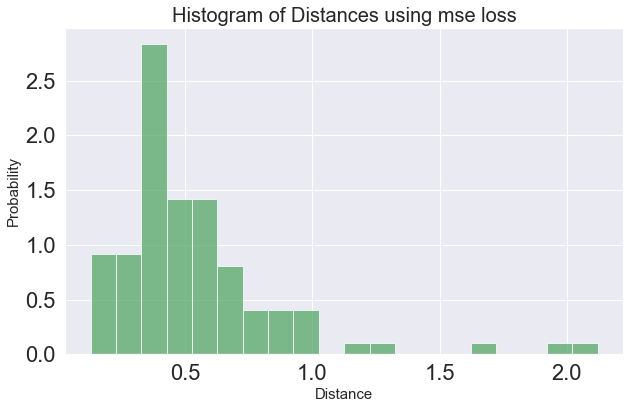

Percentile 90.00 is 0.9171


In [43]:
# Measure loss mean squared error for each data item
batch_size = 1
train_loader = torch.utils.data.DataLoader(train_data, 
                                           batch_size=batch_size, 
                                           num_workers=num_workers)
test_loader = torch.utils.data.DataLoader(test_data, 
                                          batch_size=batch_size, 
                                          num_workers=num_workers)

# Calcuate loss for normal training data 
loss_train = get_loss(model, criterion, train_loader)

# Calculate threshold for normal training data
threshold = dict_nn["threshold"]
distance_threshold = np.percentile(loss_train, threshold)

# Plot the distribution of normal error loss
plotHist(loss_train, "mse loss")
print("Percentile {0:.2f} is {1:.4f}".
          format(threshold, distance_threshold) )

Neural networks : 22 outliers
[1 1 1 1 1 1 1 1 1 1 1 1 0 0 1 0 0 1 0 1 1 0 1 0 1 1 1 1 0 1]

Recall 1.0000
Precision 0.4545


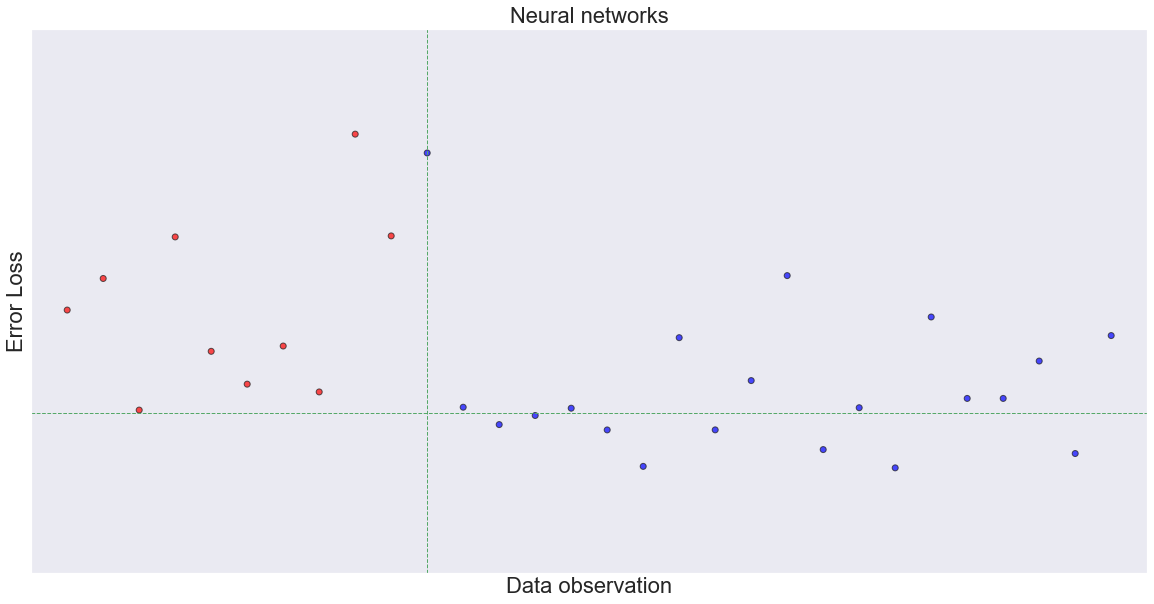

In [44]:
# Calcuate loss for test data 
# and identify outliers to those data points that exceed the threshold
loss_test = get_loss(model, criterion, test_loader)
pred = np.zeros(num_distances_test).astype(int)
pred[loss_test>=distance_threshold] = 1

# The first 10 data items are known outliers
print("Neural networks :",(pred==1).sum(),"outliers")
print(pred)
print("\nRecall {0:.4f}".format(recall_score(y_test, pred)))
print("Precision {0:.4f}".format(precision_score(y_test, pred)))
    
plot2dims(range(num_distances_test), loss_test, y_test,
              "Neural networks", "Data observation", "Error Loss", 
              horizontal_line = distance_threshold,
              vertical_line = 10)

#### Findings:
The autoencoder did find all true positive outliers, but missed some false negatives.

From all the Semi-sipervised anomaly detectors, using Euclidean distance from centrod demonstraed to be the most acurate method for this particular dataset.

## Conclusions:

Unsupervised anomaly detectors are primarly used to detect outliers or observations that are far from the others when we know for sure that there is a high concentratoin of normal data instances, and a few deviant observations.

Semi-supervised anomaly detectors are used to detect whether a new observation is an outlier or not. These methods can be used as real-time monitors of normality compliance having off-line training of normal data. 

In this exercise, we knew which observations were outliers, so we could measure the effectiveness of methods by using Recall and Precision statistics. In real-life projects one should have a continuous improvement process to evaluate the accuracy of our predictions, and refine the model specially focusing in capturing all true positive events.


#### References

2.7. Novelty and Outlier Detection
https://scikit-learn.org/stable/modules/outlier_detection.html

How to use machine learning for anomaly detection and condition monitoring
https://towardsdatascience.com/how-to-use-machine-learning-for-anomaly-detection-and-condition-monitoring-6742f82900d7

Mahalonobis Distance – Understanding the math with examples (python)
https://www.machinelearningplus.com/statistics/mahalanobis-distance/
